In [1]:
#Install libs
#!pip install lifelines
#!pip install -U yellowbrick

In [2]:
#from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
from tqdm.notebook import trange, tqdm
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from datetime import date
import warnings
warnings.filterwarnings("ignore")

#### Reading datasets

In [3]:
df_expression = pd.read_table('TCGA-BRCA-matrix-fpkm.tsv') # Gene dataset
df_clinical = pd.read_table('TCGA-BRCA.clinical.tsv') # Clinical dataset
df_protein = pd.read_table('protein_coding.tsv', header=None) # List of protein genes

#### Clinical dataset

In [4]:
df_clinical

,bcr_patient_barcode,subtype.pan,Immune.Subtype,TCGA.Subtype,pathologic_stage,ajcc_pathologic_stage,BRCA_Pathology,BRCA_Subtype_PAM50,vital_status.clinical,days_to_birth.clinical,...,tobacco_smoking_history,CNV.Clusters,Mutation.Clusters,DNA.Methylation.Clusters,mRNA.Clusters,miRNA.Clusters,lncRNA.Clusters,Protein.Clusters,PARADIGM.Clusters,Pan-Gyn.Clusters
0,TCGA-E9-A295,LumA,C1,LumA,Stage_II,Stage II,ILC,LumA,Alive,-25957.0,...,NaN,C4,C6,C2,C1,C2,C2,C1,C5,C1
1,TCGA-AO-A0J9,LumA,C1,LumA,Stage_III,Stage III,NaN,LumA,Alive,-22642.0,...,NaN,C1,C9,C2,C2,C3,C2,C1,C6,C1
2,TCGA-E2-A1L7,Normal,C2,Normal,Stage_III,Stage III,IDC,LumB,Alive,-14854.0,...,NaN,C4,C1,C2,C2,C3,C3,C1,C4,C5
3,TCGA-E2-A1L7,LumB,C2,LumB,Stage_III,Stage III,IDC,LumB,Alive,-14854.0,...,NaN,C4,C1,C2,C2,C3,C3,C1,C4,C5
4,TCGA-BH-A0HF,LumA,C1,LumA,Stage_I,Stage I,IDC,LumA,Alive,-28233.0,...,NaN,NaN,C5,C1,C1,C3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,TCGA-E2-A15E,LumA,C1,LumA,Stage_II,Stage II,IDC,LumA,Alive,-14894.0,...,NaN,C4,C4,C1,C2,C2,C1,C1,C6,C4
1215,TCGA-E2-A15E,LumA,C1,LumA,Stage_II,Stage II,IDC,LumA,Alive,-14894.0,...,NaN,C4,C4,C1,C2,C2,C1,C1,C6,C4
1216,TCGA-AR-A0U1,Basal,NaN,Basal,Stage_II,Stage II,Other,Basal,Alive,-13467.0,...,NaN,C4,C1,C4,C6,NaN,C3,C5,NaN,C3
1217,TCGA-BH-A0B2,LumA,C2,LumA,NaN,NaN,Mixed,LumA,NaN,NaN,...,NaN,NaN,NaN,C1,C2,C3,NaN,C1,C6,C1


#### Genetic dataset

In [5]:
df_expression

,gene_id,TCGA-3C-AAAU,TCGA-3C-AALI,TCGA-3C-AALJ,TCGA-3C-AALK,TCGA-4H-AAAK,TCGA-5L-AAT0,TCGA-5L-AAT1,TCGA-5T-A9QA,TCGA-A1-A0SB,...,TCGA-UL-AAZ6,TCGA-UU-A93S,TCGA-V7-A7HQ,TCGA-W8-A86G,TCGA-WT-AB41,TCGA-WT-AB44,TCGA-XX-A899,TCGA-XX-A89A,TCGA-Z7-A8R5,TCGA-Z7-A8R6
0,ENSG00000000003.13,2.476427,2.420345,12.549974,12.210248,11.642803,18.220889,8.222968,10.036685,18.494097,...,3.462053,2.432942,12.322856,25.231009,11.564670,5.247735,8.841499,8.356437,15.059694,8.497590
1,ENSG00000000005.5,0.021430,0.032542,1.403222,0.046197,0.190965,0.088919,0.074797,0.017916,7.602179,...,0.010363,0.702876,0.075491,0.273845,0.383737,0.494095,0.250236,13.418586,0.182201,0.077212
2,ENSG00000000419.11,26.827419,39.609199,46.289504,21.397945,24.470661,21.847557,31.095284,52.980863,19.931779,...,16.062762,34.246827,14.258561,29.087645,22.976892,16.998403,25.288311,21.304009,25.518702,32.854496
3,ENSG00000000457.12,2.789583,11.113364,2.941420,4.333150,3.647937,3.444317,5.569495,5.908836,3.506889,...,3.180368,5.863935,1.370262,5.852600,2.214075,4.781853,4.916745,3.509261,3.886038,4.019787
4,ENSG00000000460.15,1.118863,2.401440,2.024126,1.648454,1.428980,1.410723,1.177259,2.653853,1.271071,...,1.381314,3.197676,0.378858,1.641093,0.632738,1.022084,1.430741,1.727275,0.755291,4.318419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60478,ENSGR0000275287.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60479,ENSGR0000276543.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60480,ENSGR0000277120.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60481,ENSGR0000280767.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Conjunto de dados dos genes de proteinas

In [6]:
df_protein.head()

,0
0,ENSG00000186092
1,ENSG00000237683
2,ENSG00000235249
3,ENSG00000185097
4,ENSG00000269831


### Tratamento para inserir idade

In [7]:
df_clinical['age'] = date.today().year - df_clinical['year_of_birth']

In [8]:
print("Number of patients {}".format(len(pd.unique(df_clinical['bcr_patient_barcode']))))

Quantidade de pacientes na base de dados clinica 1098


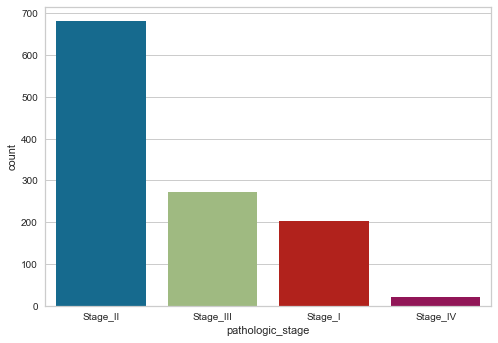

In [9]:
stage_plot = sns.countplot(data=df_clinical, x='pathologic_stage')
stage_plot.figure.savefig("stage_plot.png",dpi=200)

In [10]:
df_clinical['pathologic_stage'].value_counts()

Stage_II     682
Stage_III    273
Stage_I      203
Stage_IV      21
Name: pathologic_stage, dtype: int64

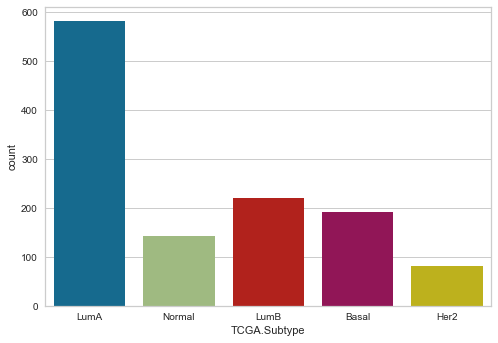

In [11]:
subtype_plot = sns.countplot(data=df_clinical, x='TCGA.Subtype')
subtype_plot.figure.savefig("subtype_plot.png",dpi=200)

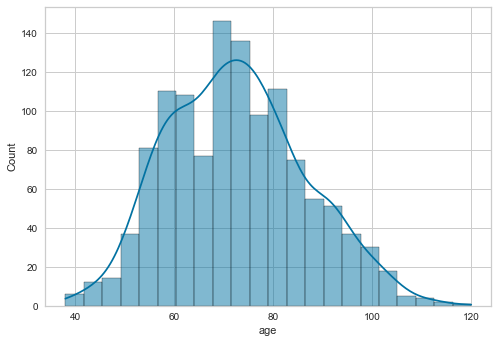

In [12]:
age_histogram = sns.histplot(df_clinical, x='age', kde=True)
age_histogram.figure.savefig("age_histogram.png",dpi=200)

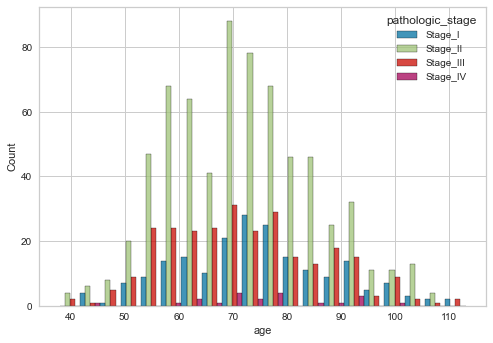

In [13]:
age_stage_histogram = sns.histplot(df_clinical, x='age', hue='pathologic_stage',multiple="dodge", hue_order=["Stage_I", "Stage_II", "Stage_III", "Stage_IV"])
age_stage_histogram.figure.savefig("age_stage_histogram.png",dpi=200)

In [14]:
print("The last day found {}".format(df_clinical['days_to_last_follow_up'].max()))

Último registro do estudo foi no dia 8605.0


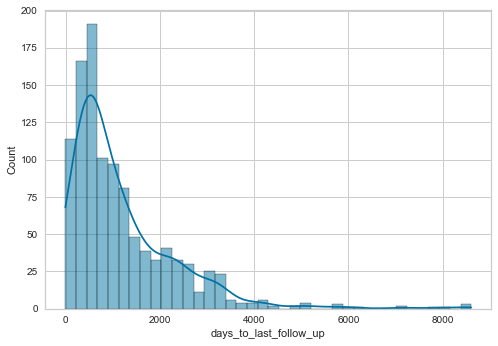

In [15]:
follow_up_hist = sns.histplot(df_clinical, x='days_to_last_follow_up', kde=True)
follow_up_hist.figure.savefig("follow_up_hist.png",dpi=200)

In [16]:
df_clinical['vital_status.clinical'].value_counts()

Alive    1018
Dead      199
Name: vital_status.clinical, dtype: int64

#### Filter stage of patients

In [17]:
print("Quantidade de pacientes por estágio:\n{}".format(str(df_clinical['pathologic_stage'].value_counts())))
df_clinical = df_clinical[(df_clinical['pathologic_stage'] == 'Stage_II') | (df_clinical['pathologic_stage'] == 'Stage_I')]

Quantidade de pacientes por estágio:
Stage_II     682
Stage_III    273
Stage_I      203
Stage_IV      21
Name: pathologic_stage, dtype: int64


In [18]:
df_clinical = df_clinical[['bcr_patient_barcode','days_to_last_follow_up', 'vital_status.clinical','TCGA.Subtype', 'pathologic_stage', 'age']]

In [19]:
df_clinical = df_clinical[df_clinical['bcr_patient_barcode'].isin(df_expression.columns.tolist())]
df_clinical = df_clinical.dropna()
df_clinical = df_clinical.reset_index(drop=True)


In [20]:
df_clinical.head()

,bcr_patient_barcode,days_to_last_follow_up,vital_status.clinical,TCGA.Subtype,pathologic_stage,age
0,TCGA-E9-A295,375.0,Alive,LumA,Stage_II,82.0
1,TCGA-BH-A0HF,727.0,Alive,LumA,Stage_I,91.0
2,TCGA-A8-A08H,0.0,Alive,Normal,Stage_II,81.0
3,TCGA-A7-A6VW,285.0,Alive,Basal,Stage_II,57.0
4,TCGA-EW-A1OY,908.0,Alive,LumB,Stage_II,76.0


In [21]:
print("Max value gene {} min value gene {}".format(df_expression.set_index("gene_id").to_numpy().max(),df_expression.set_index("gene_id").to_numpy().min()))

Max value gene 430170.048935 min value gene 0.0


In [22]:
df_expression=(df_expression.set_index("gene_id")-df_expression.set_index("gene_id").min())/(df_expression.set_index("gene_id").max()-df_expression.set_index("gene_id").min())
df_expression=df_expression.reset_index()

#### Selection only protein genes

In [23]:
print("All genes size {}".format(len(df_expression)))
df_expression = df_expression[df_expression['gene_id'].apply(lambda x: x.split('.')[0] in df_protein[0].tolist())]
print("Protein genes size {}".format(len(df_expression)))

Quantidade de genes no conjunto 60483
Quantidade de genes no conjunto reduzido 19595


In [24]:
df_expression_transpose = df_expression.copy(deep=True)
df_expression_transpose = df_expression.T
df_expression_transpose = df_expression_transpose.reset_index()
df_expression_transpose.columns = df_expression_transpose.iloc[0]
df_expression_transpose = df_expression_transpose.iloc[1:]
df_expression_transpose = df_expression_transpose.set_index('gene_id')
results_global = {}

In [25]:
from sklearn.model_selection import train_test_split
df_clinical_exp = df_clinical.merge(df_expression_transpose.reset_index(), left_on="bcr_patient_barcode", right_on="gene_id")

dead_indexes = df_clinical[df_clinical['vital_status.clinical'] == 'Dead'].index.tolist()
indexes = [i for i in range(len(df_clinical)) if i not in dead_indexes]
df_to_split = df_clinical.iloc[indexes]
test_size = .3
index_dead_test = int(len(dead_indexes)*test_size)
df_train, df_test = train_test_split(df_to_split, test_size = test_size)
train_indexes = df_train.index.tolist() + dead_indexes[index_dead_test:]
test_indexes = df_test.index.tolist() + dead_indexes[:index_dead_test]

In [26]:
print(len(train_indexes), len(test_indexes))

555 238


In [27]:
df_clinical['vital_status.clinical'].value_counts()

Alive    762
Dead      31
Name: vital_status.clinical, dtype: int64

In [28]:
print("Quantidade de pacientes por estágio:\n{}".format(str(df_clinical['TCGA.Subtype'].value_counts())))

Quantidade de pacientes por estágio:
LumA      387
Basal     144
LumB      132
Normal     79
Her2       51
Name: TCGA.Subtype, dtype: int64


#### Filtrando os dados de expressão genica para genes de proteína.

#### Elbow method

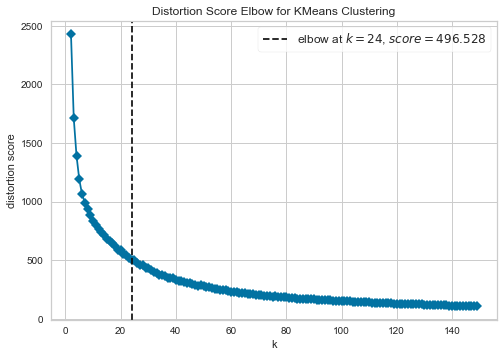

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
model = KMeans(random_state=12)
r = (2,150)
visualizer = KElbowVisualizer(model, k=r, timings=False, title='')
visualizer.fit(df_expression.set_index('gene_id'))
visualizer.show()

#### Merging clinical and genetic data

In [30]:
df_exp_merge = df_expression_transpose
df_clinical_exp = df_clinical.merge(df_exp_merge.reset_index(), left_on="bcr_patient_barcode", right_on="gene_id")

In [33]:
df_clinical_exp

,bcr_patient_barcode,days_to_last_follow_up,vital_status.clinical,TCGA.Subtype,pathologic_stage,age,gene_id,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,...,ENSG00000273173.4,ENSG00000273217.1,ENSG00000273259.2,ENSG00000273269.1,ENSG00000273274.1,ENSG00000273291.4,ENSG00000273294.1,ENSG00000273303.1,ENSG00000273331.1,ENSG00000273398.4
0,TCGA-E9-A295,375.0,Alive,LumA,Stage_II,82.0,TCGA-E9-A295,0.001473,0.000022,0.002539,...,0.000042,0.0,0.000627,0.0,0.000001,0.000007,0.000005,0.0,0.0,0.0
1,TCGA-BH-A0HF,727.0,Alive,LumA,Stage_I,91.0,TCGA-BH-A0HF,0.003753,0.000056,0.004513,...,0.000057,0.0,0.000207,0.0,0.000001,0.000048,0.000001,0.0,0.000021,0.0
2,TCGA-A8-A08H,0.0,Alive,Normal,Stage_II,81.0,TCGA-A8-A08H,0.000569,0.000042,0.001668,...,0.000001,0.0,0.000008,0.0,0.0,0.000022,0.000001,0.0,0.000009,0.0
3,TCGA-A7-A6VW,285.0,Alive,Basal,Stage_II,57.0,TCGA-A7-A6VW,0.002497,0.000005,0.003192,...,0.000039,0.0,0.000043,0.000002,0.000001,0.000018,0.0,0.0,0.000013,0.0
4,TCGA-EW-A1OY,908.0,Alive,LumB,Stage_II,76.0,TCGA-EW-A1OY,0.000904,0.000004,0.005016,...,0.000049,0.0,0.000055,0.0,0.000003,0.000034,0.000002,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,TCGA-E2-A150,1935.0,Alive,Basal,Stage_II,61.0,TCGA-E2-A150,0.002556,0.000004,0.006733,...,0.000015,0.0,0.000101,0.0,0.0,0.000043,0.0,0.0,0.0,0.0
789,TCGA-C8-A3M8,394.0,Alive,LumB,Stage_I,79.0,TCGA-C8-A3M8,0.000722,0.000031,0.001871,...,0.000008,0.0,0.000042,0.0,0.000001,0.000026,0.000002,0.0,0.000002,0.0
790,TCGA-C8-A12K,0.0,Alive,Basal,Stage_II,92.0,TCGA-C8-A12K,0.001301,0.000003,0.003834,...,0.000015,0.0,0.000079,0.0,0.00001,0.000023,0.000001,0.0,0.000007,0.0
791,TCGA-E2-A15E,630.0,Alive,LumA,Stage_II,53.0,TCGA-E2-A15E,0.001274,0.000006,0.004165,...,0.000067,0.0,0.00009,0.0,0.000009,0.000047,0.000006,0.0,0.000003,0.000001


### Approach to select genes by K-means and survival predict (Cox)

In [34]:
# Calculando o atributo de cada cluster mais proximo do centroíde
results_kmeans_k = []
results_kmeans = []
genes_selects = []
models = []
df_expression_to_kmeans = df_expression.set_index("gene_id")
for k_value in range(15,101):
    best_kmeans = KMeans(n_clusters=k_value, random_state=12)
    y_kmeans = best_kmeans.fit_predict(df_expression_to_kmeans)
    min_feature_by_cluster = {'feature_name':['None']*k_value, 'min_dist':[float('inf')]*k_value}
    distances = best_kmeans.transform(df_expression_to_kmeans)
    for i in range(len(y_kmeans)):
      if min_feature_by_cluster['min_dist'][y_kmeans[i]] > distances[i][y_kmeans[i]]:
        min_feature_by_cluster['min_dist'][y_kmeans[i]] = distances[i][y_kmeans[i]]
        min_feature_by_cluster['feature_name'][y_kmeans[i]] = df_expression_to_kmeans.index[i]


    clinical_features = ['days_to_last_follow_up', 'vital_status.clinical','TCGA.Subtype', 'pathologic_stage', 'age']
    categorics = ['TCGA.Subtype', 'pathologic_stage']
    df_cox_kmeans = df_clinical_exp[clinical_features+min_feature_by_cluster['feature_name']]
    df_cox_kmeans['vital_status.bin'] = df_cox_kmeans['vital_status.clinical'].apply(lambda row: 1 if row == 'Dead' else 0)
    df_cox_kmeans = df_cox_kmeans.drop(columns=['vital_status.clinical'])
    df_cox_kmeans = df_cox_kmeans.dropna()
    for cat in categorics:
      hot = OneHotEncoder()
      results = hot.fit_transform(df_cox_kmeans[[cat]])
      df_cox_kmeans = df_cox_kmeans.drop(columns=[cat])
      for enc in range(len(hot.categories_[0])):
        if enc == 0:
          continue
        df_cox_kmeans[hot.categories_[0][enc]] = results.toarray()[:, enc] 
    cph_kmeans = CoxPHFitter()
    try:
        cph_kmeans.fit(df_cox_kmeans.iloc[train_indexes], duration_col='days_to_last_follow_up', event_col='vital_status.bin', show_progress=False)
        results_kmeans_k.append(k_value)
        genes_selects.append(min_feature_by_cluster['feature_name'])
        results_kmeans.append(cph_kmeans.score(df_cox_kmeans.iloc[test_indexes],scoring_method='concordance_index'))
        models.append(cph_kmeans)
        print("K_CLUSTER {} WITH C-INDEX TRAIN {} AND C-INDEX TEST {}".format(k_value, cph_kmeans.score(df_cox_kmeans.iloc[train_indexes],scoring_method='concordance_index'), cph_kmeans.score(df_cox_kmeans.iloc[test_indexes],scoring_method='concordance_index')))
    except:
        continue

K_CLUSTER 15 WITH C-INDEX TRAIN 0.8270338625825489 AND C-INDEX TEST 0.6779808529155787
K_CLUSTER 16 WITH C-INDEX TRAIN 0.8628635661093157 AND C-INDEX TEST 0.7536988685813751
K_CLUSTER 17 WITH C-INDEX TRAIN 0.8601939019249684 AND C-INDEX TEST 0.7554395126196692
K_CLUSTER 18 WITH C-INDEX TRAIN 0.8503582970352677 AND C-INDEX TEST 0.721496953872933
K_CLUSTER 19 WITH C-INDEX TRAIN 0.8625825488267529 AND C-INDEX TEST 0.6910356832027851
K_CLUSTER 20 WITH C-INDEX TRAIN 0.9083883658845019 AND C-INDEX TEST 0.7954743255004352
K_CLUSTER 21 WITH C-INDEX TRAIN 0.8620205142616271 AND C-INDEX TEST 0.7597911227154047
K_CLUSTER 22 WITH C-INDEX TRAIN 0.8764929043136153 AND C-INDEX TEST 0.8102697998259356
K_CLUSTER 23 WITH C-INDEX TRAIN 0.8870310524097232 AND C-INDEX TEST 0.731940818102698
K_CLUSTER 24 WITH C-INDEX TRAIN 0.8814107067584657 AND C-INDEX TEST 0.7354221061792864
K_CLUSTER 25 WITH C-INDEX TRAIN 0.912603625122945 AND C-INDEX TEST 0.835509138381201
K_CLUSTER 26 WITH C-INDEX TRAIN 0.8925108894196

<AxesSubplot:xlabel='k_values', ylabel='C-index test'>

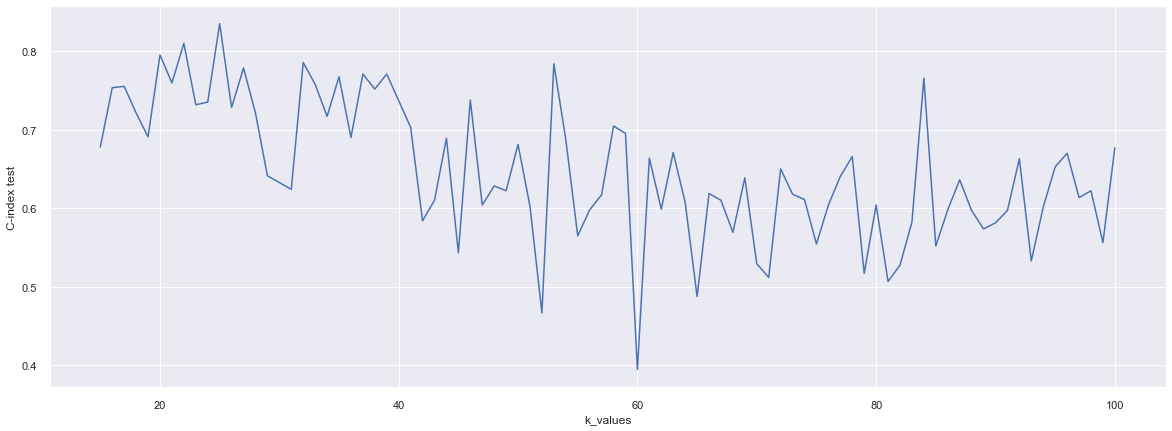

In [35]:
sns.set(rc={'figure.figsize':(20,7)})
df_results = pd.DataFrame({'k_values':results_kmeans_k, 'C-index test': results_kmeans})
sns.lineplot(x='k_values', y='C-index test', data=df_results)

In [36]:
print('Best C-index {} and K_value {}'.format(max(results_kmeans),results_kmeans_k[results_kmeans.index(max(results_kmeans))]))


Best C-index 0.835509138381201 and K_value 25


<AxesSubplot:xlabel='k_values', ylabel='values'>

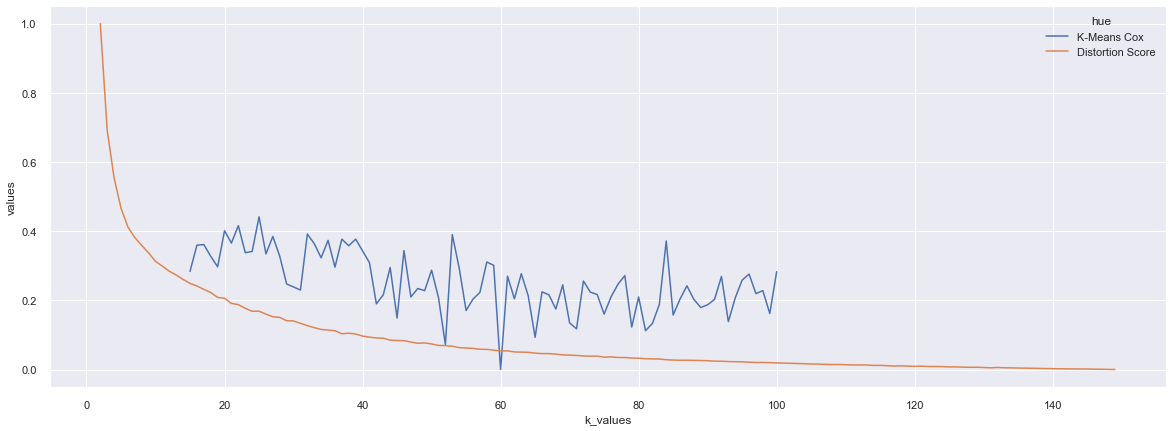

In [38]:
k_scores_normalized = []
max_k = max(visualizer.k_scores_)
min_k = min(visualizer.k_scores_)
for i in visualizer.k_scores_:
    k_scores_normalized.append((i-min_k)/(max_k-min_k))
k_values = results_kmeans_k+[i for i in range(2,150)]
min_score = min(results_kmeans)
values = ([i-min_score for i in results_kmeans])+k_scores_normalized
hue = (['K-Means Cox']*len(results_kmeans))+(['Distortion Score']*len(k_scores_normalized))

df_results = pd.DataFrame({'k_values':k_values, 'values': values, 'hue':hue})
sns.lineplot(x='k_values', y='values', hue='hue', data=df_results)

# Cox model only clinical data

In [39]:
import itertools
combinations = []
from sklearn.model_selection import train_test_split
df_clinical_exp = df_clinical.merge(df_expression_transpose.reset_index(), left_on="bcr_patient_barcode", right_on="gene_id")

dead_indexes = df_clinical[df_clinical['vital_status.clinical'] == 'Dead'].index.tolist()
indexes = [i for i in range(len(df_clinical)) if i not in dead_indexes]
df_to_split = df_clinical.iloc[indexes]
test_size = .3
index_dead_test = int(len(dead_indexes)*test_size)
df_train, df_test = train_test_split(df_to_split, test_size = test_size)
train_indexes = df_train.index.tolist() + dead_indexes[index_dead_test:]
test_indexes = df_test.index.tolist() + dead_indexes[:index_dead_test]
for i in range(1,4):
    combs = list(itertools.combinations(['TCGA.Subtype', 'pathologic_stage', 'age'], i))
    for c in combs:
        combinations.append(list(c))
results_clinical = []     
for comb in combinations:
    clinical_features = ['days_to_last_follow_up', 'vital_status.clinical']+comb
    categorics = [x for x in comb if x in ['TCGA.Subtype', 'pathologic_stage']]
    df_cox = df_clinical[clinical_features]
    df_cox['vital_status.bin'] = df_clinical['vital_status.clinical'].apply(lambda row: 1 if row == 'Dead' else 0)
    df_cox = df_cox.drop(columns=['vital_status.clinical'])
    df_cox = df_cox.dropna()
    for cat in categorics:
      hot = OneHotEncoder()
      results = hot.fit_transform(df_cox[[cat]])
      df_cox = df_cox.drop(columns=[cat])
      for enc in range(len(hot.categories_[0])):
        if enc == 0:
          continue
        df_cox[hot.categories_[0][enc]] = results.toarray()[:, enc] 
    cph_dados_clinicos = CoxPHFitter()
    cph_dados_clinicos.fit(df_cox.iloc[train_indexes], duration_col='days_to_last_follow_up', event_col='vital_status.bin', show_progress=False)
    results_clinical.append({'features':comb, 'cindex':cph_dados_clinicos.score(df_cox.iloc[test_indexes], scoring_method='concordance_index')})
cph_dados_clinicos.summary[['coef','p']]

,coef,p
covariate,,
age,0.056882,0.004843
Her2,0.605326,0.554547
LumA,-0.113974,0.887790
LumB,0.247899,0.787204
Normal,1.327491,0.113091
Stage_II,1.363153,0.070483
